In [12]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn import preprocessing

import kdquantile

In [121]:
n = 10000
alpha_list = [0.1, 1., 10.]
n_quantiles_list = [30, 100, 300, 1000, 3000, 10000]
exact_times = np.zeros((len(alpha_list),))
gaussian_times = np.zeros((len(alpha_list), len(n_quantiles_list)))
polyexp_times = np.zeros((len(alpha_list),))
gaussian_errs = np.zeros((len(alpha_list), len(n_quantiles_list)))
polyexp_errs = np.zeros((len(alpha_list),))

rng = np.random.RandomState(0)
X_train = rng.lognormal(size=(n, 1))
X_test = np.linspace(X_train.min(), X_train.max(), n).reshape(-1, 1)

for aix, alpha in enumerate(alpha_list):

    kdqer = kdquantile.KDQuantileTransformer(kernel="gaussian", alpha=alpha, exact=True)
    exact_time = time.time()
    kdqer.fit(X_train)
    Y_test_exact = kdqer.transform(X_test)
    exact_times[aix] = time.time() - exact_time

    kdqer = kdquantile.KDQuantileTransformer(kernel="polyexp", alpha=alpha, polyexp_order=4)
    polyexp_time = time.time()
    kdqer.fit(X_train)
    Y_test_polyexp = kdqer.transform(X_test)
    polyexp_times[aix] = time.time() - polyexp_time
    polyexp_errs[aix] = np.max(np.abs(Y_test_exact - Y_test_polyexp))
    
    for qix, n_quantiles in enumerate(n_quantiles_list):
        kdqer = kdquantile.KDQuantileTransformer(kernel="gaussian", alpha=alpha, n_quantiles=n_quantiles)
        gaussian_time = time.time()
        kdqer.fit(X_train)
        Y_test_gaussian = kdqer.transform(X_test)
        gaussian_times[aix, qix] = time.time() - gaussian_time
        gaussian_errs[aix, qix] = np.max(np.abs(Y_test_exact - Y_test_gaussian))

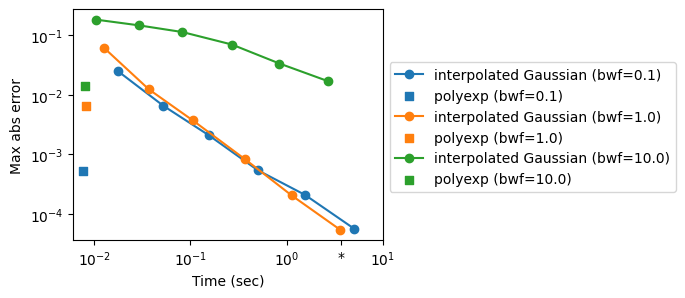

In [125]:
plt.figure(figsize=(4, 3))
for aix, alpha in enumerate(alpha_list):
    line, = plt.plot(
        gaussian_times[aix, :], gaussian_errs[aix, :], marker='o', 
        label=f'interpolated Gaussian (bwf={str(alpha)})');
    plt.scatter(
        polyexp_times[aix], polyexp_errs[aix], marker='s', c=line.get_color(), 
        label=f'polyexp (bwf={alpha})');
    plt.legend(bbox_to_anchor=(1, 0.8));
plt.xscale('log');
plt.yscale('log');
plt.xlim(0.6 * 1e-2, 1.1 * np.mean(exact_times));
plt.xticks([1e-2, 1e-1, 1., np.mean(exact_times), 10], ['$10^{-2}$', '$10^{-1}$', '$10^{0}$', '*', '$10^{1}$']);
plt.xlabel('Time (sec)');
plt.ylabel('Max abs error');
plt.minorticks_off()
plt.savefig('Gaussian-vs-polyexp.pdf');